# Photoacoustics with LDV - Data Analysis 

In [46]:
# load data for differnt concentrion

import h5py
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal



hf = h5py.File('data.h5','r')
list(hf.keys())
concentration0 = hf['concentrations/pdms_middle_10s_500ns_1pld_0pcm_velocity']
concentration1 = hf['concentrations/pdms_middle_10s_500ns_1pld_10pcm_velocity']
concentration2 = hf['concentrations/pdms_middle_10s_500ns_1pld_25pcm_velocity']
concentration3 = hf['concentrations/pdms_middle_10s_500ns_1pld_50pcm_velocity']
concentration4 = hf['concentrations/pdms_middle_10s_500ns_1pld_100pcm_velocity']
concentration5 = hf['concentrations/pdms_middle_10s_500ns_1pld_250pcm_velocity']
concentration6 = hf['concentrations/pdms_middle_10s_500ns_1pld_500pcm_velocity']
concentration7 = hf['concentrations/pdms_middle_10s_500ns_1pld_1000pcm_velocity']

c0 = np.squeeze(np.array(concentration0))
c1 = np.squeeze(np.array(concentration1))
c2 = np.squeeze(np.array(concentration2))
c3 = np.squeeze(np.array(concentration3))
c4 = np.squeeze(np.array(concentration4))
c5 = np.squeeze(np.array(concentration5))
c6 = np.squeeze(np.array(concentration6))
c7 = np.squeeze(np.array(concentration7))
c0.shape

(2048,)

In [47]:
# data processing and filtering
pretrig = 248
fs = 65e6
time = np.linspace(-pretrig/fs, (len(c0)-pretrig)/fs, len(c0))*1e6

# function for applying butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b,a,data)
    return y

concentration_data = np.array([c0, c1, c2, c3, c4, c5, c6, c7])
concentration_data.shape
# apply filter  each concentration

filtered_data = np.zeros((8, len(c0)))
for i in range(8):
    filtered_data[i] = butter_lowpass_filter(concentration_data[i], 5e6, fs, order=5)

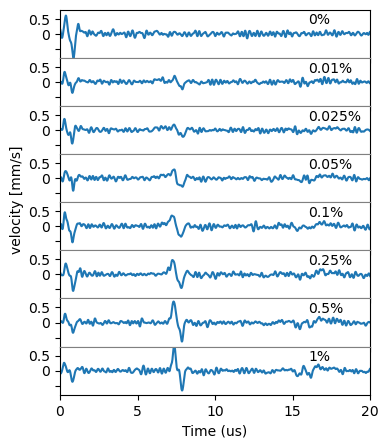

In [48]:
fig = plt.figure(figsize=(4,5))
gs = fig.add_gridspec(8,1, hspace=0)
ax = gs.subplots(sharex=True)

concentration_labels = ['0', '0.01', '0.025', '0.05', '0.1', '0.25', '0.5', '1']
for i in range(8):
    ax[i].plot(time, filtered_data[i]*1e3)
    ax[i].set_ylim(-0.8, 0.8)
    ax[i].set_xlim(0, 20)
    # change color of bottom and top boundary to grey except for bottom plot
    if i != 7:
        ax[i].spines['bottom'].set_color('grey')
    if i != 0:
        ax[i].spines['top'].set_color('grey')
    # show only 0 and 0.5 on ylabels
    ax[i].set_yticks([-0.5, 0, 0.5], ['',0,0.5])
    # put in every plot the concentration
    ax[i].text(0.8, 0.7, concentration_labels[i]+'%', transform=ax[i].transAxes)
    
ax[7].set_xlabel('Time (us)')
# create a global y label
fig.text(0.0, 0.5, 'velocity [mm/s]', va='center', rotation='vertical')


plt.show()



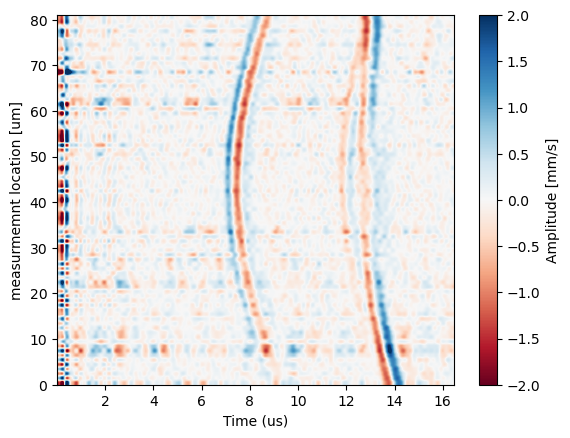

In [67]:
time = np.linspace(-pretrig/fs, (len(c0)-pretrig)/fs, len(c0))*1e6
scan_data = hf['scans/pdms_middle_1s_10mm_125umstep_1000pcm_velocity']

pretrig = 530

# Slice the time and filtered_data arrays
time = time[pretrig:]
filtered_data2 = filtered_data[:, pretrig:]


# Apply the filter to each time series in scan_data
filtered_data = np.empty(scan_data.shape)
for i in range(scan_data.shape[0]):
    filtered_data[i, :] = butter_lowpass_filter(scan_data[i, :]*1e3, 3e6, fs, order=5)


time = np.linspace(-pretrig/fs, (len(filtered_data[1,:])-pretrig)/fs, len(filtered_data[1,:]))*1e6

#pretrig = 248

# Slice the time and filtered_data arrays
time = time[pretrig:1600]
filtered_data = filtered_data[:, pretrig:1600]

# Define the bounds
left = time[0]
right = time[-1]
bottom = 0
top = filtered_data.shape[0]  # assuming the y-axis should be the index of the time series

# Make a 2d plot of the filtered data
plt.imshow(filtered_data, aspect='auto', cmap='RdBu', vmin=-2, vmax=2, extent=[left, right, bottom, top])
plt.colorbar(label='Amplitude [mm/s]')

plt.xlabel('Time (us)')
plt.ylabel('measurmemnt location [um]')
plt.show()




# the data in this file is processed using matlabs kwave toolbox with the script    ....m
